In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_table('newsCorpora.csv', header=None, names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])
data.query(("PUBLISHER=='Reuters' | PUBLISHER=='Huffington Post' | PUBLISHER=='Businessweek' | PUBLISHER=='Contactmusic.com' | PUBLISHER=='Daily Mail'"), inplace=True)
data = data.sample(frac =1)
train, subtest = train_test_split(data, train_size=0.8)
test, valid = train_test_split(subtest, train_size=0.5)
print(train.shape, valid.shape, test.shape)

train = train[['TITLE', 'CATEGORY']]
valid = valid[['TITLE', 'CATEGORY']]
test = test[['TITLE', 'CATEGORY']]
print(train.shape, valid.shape, test.shape)

train.to_csv('train.txt', sep='\t', index=False)
valid.to_csv('valid.txt', sep='\t', index=False)
test.to_csv('test.txt', sep='\t', index=False)

(10672, 8) (1334, 8) (1334, 8)
(10672, 2) (1334, 2) (1334, 2)


In [20]:
import string
import re

def preprocessing(text):
  table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  text = text.translate(table)  # 記号をスペースに置換
  text = text.lower()  # 小文字化
  text = re.sub('[0-9]+', '0', text)  # 数字列を0に置換

  return text

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

#detaの再結合とインデックスの更新
data = pd.concat([train, valid, test], axis=0)
data.reset_index(drop=True, inplace=True) 

#detaの前処理
data['TITLE'] = data['TITLE'].map(lambda x: preprocessing(x))
print(data.head())

#tfidf計算のモデルを作成
vectorizer = TfidfVectorizer(min_df=10, ngram_range=(1, 2))

#データの分割
train_valid = data[:len(train)+len(valid)]
train = train_valid[:len(train)]
valid = train_valid[len(train):]
test = data[len(train)+len(valid):]

#データの保存
train.to_csv('train.txt', sep='\t', index=False)
valid.to_csv('valid.txt', sep='\t', index=False)
test.to_csv('test.txt', sep='\t', index=False)

#tfidfの計算と行列変換
X_train_valid = vectorizer.fit_transform(train_valid['TITLE']).toarray()
X_test = vectorizer.transform(test['TITLE']).toarray()
                                         
#行列をDatafram型に変換
X_train_valid = pd.DataFrame(X_train_valid, columns=vectorizer.get_feature_names())
X_test = pd.DataFrame(X_test, columns=vectorizer.get_feature_names())

#データの分割
X_train = X_train_valid[:len(train)]
X_valid = X_train_valid[len(train):len(train)+len(valid)]

print(X_train.head())

                                               TITLE CATEGORY
0  update 0 us wins car import duties trade case ...        b
1  forex dollar gains against euro as draghi hint...        b
2  will smith   willow smith causes a stir with c...        e
3  qatar reprises distressed investor role with d...        b
4  update 0 gm to invest  0 bln in china and plan...        b
    0d   0m  0million  0nd   0s  0st  0th  0th birthday   aa  abbvie  ...  \
0  0.0  0.0       0.0  0.0  0.0  0.0  0.0           0.0  0.0     0.0  ...   
1  0.0  0.0       0.0  0.0  0.0  0.0  0.0           0.0  0.0     0.0  ...   
2  0.0  0.0       0.0  0.0  0.0  0.0  0.0           0.0  0.0     0.0  ...   
3  0.0  0.0       0.0  0.0  0.0  0.0  0.0           0.0  0.0     0.0  ...   
4  0.0  0.0       0.0  0.0  0.0  0.0  0.0           0.0  0.0     0.0  ...   

   young  your  your mother   yr  yr high  yuan  zac  zac efron  zendaya  zone  
0    0.0   0.0          0.0  0.0      0.0   0.0  0.0        0.0      0.0   0.0  
1  

In [22]:
#データの保存
X_train.to_csv('train_feature.txt', sep='\t', index=False)
X_valid.to_csv('valid_feature.txt', index=False, sep='\t')
X_test.to_csv('test_feature.txt', index=False, sep='\t')

#確認
print(X_train.head())

    0d   0m  0million  0nd   0s  0st  0th  0th birthday   aa  abbvie  ...  \
0  0.0  0.0       0.0  0.0  0.0  0.0  0.0           0.0  0.0     0.0  ...   
1  0.0  0.0       0.0  0.0  0.0  0.0  0.0           0.0  0.0     0.0  ...   
2  0.0  0.0       0.0  0.0  0.0  0.0  0.0           0.0  0.0     0.0  ...   
3  0.0  0.0       0.0  0.0  0.0  0.0  0.0           0.0  0.0     0.0  ...   
4  0.0  0.0       0.0  0.0  0.0  0.0  0.0           0.0  0.0     0.0  ...   

   young  your  your mother   yr  yr high  yuan  zac  zac efron  zendaya  zone  
0    0.0   0.0          0.0  0.0      0.0   0.0  0.0        0.0      0.0   0.0  
1    0.0   0.0          0.0  0.0      0.0   0.0  0.0        0.0      0.0   0.0  
2    0.0   0.0          0.0  0.0      0.0   0.0  0.0        0.0      0.0   0.0  
3    0.0   0.0          0.0  0.0      0.0   0.0  0.0        0.0      0.0   0.0  
4    0.0   0.0          0.0  0.0      0.0   0.0  0.0        0.0      0.0   0.0  

[5 rows x 2830 columns]


In [24]:
#学習
lg = LogisticRegression(random_state=123, max_iter=10000)
lg.fit(X_train, train['CATEGORY'])

LogisticRegression(max_iter=10000, random_state=123)

In [25]:
#予測
import numpy as np

print(np.max(lg.predict_proba(X_train), axis=1), lg.predict(X_train))
print(np.max(lg.predict_proba(X_test), axis=1), lg.predict(X_test))

[0.85811791 0.97669774 0.84872639 ... 0.65263235 0.6924556  0.89396579] ['b' 'b' 'e' ... 't' 'e' 'b']
[0.50522184 0.83563889 0.61204318 ... 0.59407219 0.59460872 0.95965904] ['e' 'e' 'b' ... 'b' 'e' 'e']


In [26]:
#正解率の計算
from sklearn.metrics import accuracy_score

print(accuracy_score(train['CATEGORY'], lg.predict(X_train)))
print(accuracy_score(test['CATEGORY'], lg.predict(X_test)))
print(accuracy_score(valid['CATEGORY'], lg.predict(X_valid)))

0.9251311844077961
0.883808095952024
0.8883058470764618


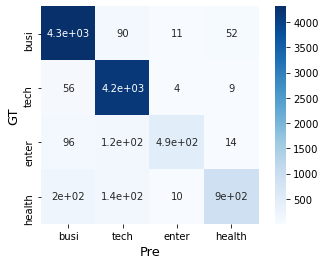

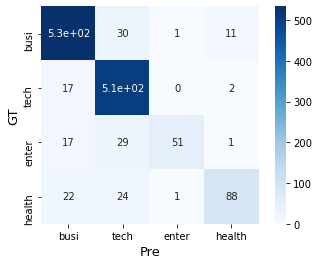

In [27]:
#混同行列の可視化
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

train_cm = confusion_matrix(train['CATEGORY'], lg.predict(X_train))
train_cm = pd.DataFrame(data=train_cm, index=["busi", "tech", "enter","health"], 
                           columns=["busi", "tech", "enter", "health"])
sns.heatmap(train_cm, square=True, cbar=True, annot=True, cmap='Blues')
plt.xlabel("Pre", fontsize=13)
plt.ylabel("GT", fontsize=13)
plt.show()

test_cm = confusion_matrix(test['CATEGORY'], lg.predict(X_test))
test_cm = pd.DataFrame(data=test_cm, index=["busi", "tech", "enter","health"], 
                           columns=["busi", "tech", "enter", "health"])
sns.heatmap(test_cm, square=True, cbar=True, annot=True, cmap='Blues')
plt.xlabel("Pre", fontsize=13)
plt.ylabel("GT", fontsize=13)
plt.show()

In [28]:
#評価指標
from sklearn.metrics import precision_score, recall_score, f1_score

def score (y_true, y_pred):
    precision = precision_score(y_true, y_pred, average=None, labels=['b', 'e', 't', 'm'])
    precision = np.append(precision, precision_score(y_true, y_pred, average='micro'))
    precision = np.append(precision, precision_score(y_true, y_pred, average='macro'))
    recall = recall_score(y_true, y_pred, average=None, labels=['b', 'e', 't', 'm'])
    recall = np.append(recall, recall_score(y_true, y_pred, average='micro'))
    recall = np.append(recall, recall_score(y_true, y_pred, average='macro'))
    f1 = f1_score(y_true, y_pred, average=None, labels=['b', 'e', 't', 'm'])
    f1 = np.append(f1, f1_score(y_true, y_pred, average='micro'))
    f1 = np.append(f1, f1_score(y_true, y_pred, average='macro'))
    return pd.DataFrame({'適合率': precision, '再現率': recall, 'F1スコア': f1},
                        index=['b', 'e', 't', 'm', 'マイクロ平均', 'マクロ平均'])

In [29]:
print(score(test["CATEGORY"], lg.predict(X_test)))

             適合率       再現率     F1スコア
b       0.905085  0.927083  0.915952
e       0.859083  0.963810  0.908438
t       0.862745  0.651852  0.742616
m       0.962264  0.520408  0.675497
マイクロ平均  0.883808  0.883808  0.883808
マクロ平均   0.897294  0.765788  0.810626


In [36]:
features = X_train.columns.to_numpy()
columns = [i for i in range(1, 11)]
for c, coef in zip(lg.classes_, lg.coef_):
    print(f'カテゴリ：{c}')
    lis = np.array([features[np.argsort(coef)[::-1][:10]], features[np.argsort(coef)[:10]]])
    frame = pd.DataFrame(lis, columns=columns, index=['重要度高', '重要度低'])
    display(frame)

カテゴリ：t


,1,2,3,4,5,6,7,8,9,10
重要度高,fed,bank,china,ecb,stocks,oil,euro,dollar,obamacare,ukraine
重要度低,and,ebola,her,she,video,microsoft,google,facebook,star,tv


カテゴリ：t


,1,2,3,4,5,6,7,8,9,10
重要度高,kardashian,chris,she,movie,star,film,kim,paul,her,jay
重要度低,update,google,us,china,study,gm,ceo,says,could,facebook


カテゴリ：t


,1,2,3,4,5,6,7,8,9,10
重要度高,ebola,study,fda,cancer,drug,mers,health,doctors,could,cases
重要度低,gm,facebook,apple,climate,bank,ceo,google,fed,deal,billion


カテゴリ：t


,1,2,3,4,5,6,7,8,9,10
重要度高,google,facebook,apple,microsoft,climate,gm,tesla,comcast,mobile,fcc
重要度低,stocks,fed,do,drug,percent,oil,ukraine,cancer,her,ecb


In [12]:
from tqdm import tqdm
x = []
train_accuracy = []
valid_accuracy = []
test_accuracy = []
for C in tqdm(np.logspace(-5, 4, 10)):
    lg = LogisticRegression(random_state=123, max_iter=10000, C=C)
    lg.fit(X_train, train['CATEGORY'])
    x.append(C)
    train_accuracy.append(accuracy_score(train['CATEGORY'], lg.predict(X_train)))
    valid_accuracy.append(accuracy_score(valid['CATEGORY'], lg.predict(X_valid)))
    test_accuracy.append(accuracy_score(test['CATEGORY'], lg.predict(X_test)))

 40%|████      | 4/10 [00:02<00:04,  1.42it/s]


KeyboardInterrupt: 

In [ ]:
plt.plot(x, train_accuracy, label='train')
plt.plot(x, valid_accuracy, label='valid')
plt.plot(x, test_accuracy, label='test')
plt.ylim(0, 1.1)
plt.ylabel('Accuracy')
plt.xscale ('log')
plt.xlabel('C')
plt.legend()
plt.show()

In [ ]:
!pip install optuna

In [ ]:

def objective_lg(trial):
    l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)
    C = trial.suggest_loguniform('C', 1e-4, 1e4)
    
    lg = LogisticRegression(random_state=123, max_iter=10000, penalty='elasticnet',solver='saga', l1_ratio=l1_ratio, C=C)
    lg.fit(X_train, train['CATEGORY'])
    valid_accuracy = accuracy_score(valid['CATEGORY'], lg.predict(X_valid))
    return valid_accuracy

In [ ]:
import optuna

study = optuna.create_study(direction='maximize')
study.optimize(objective_lg, timeout=360)

In [ ]:
trial = study.best_trial
print(f'bestvalue:{trial.value}')
for key, value in trial.params.items():
    print(f'l1_ratio:{key}')
    print(f'C:{value}')

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

C = 100
kernel = 'rbf'
gamma  = 0.01

estimator = SVC(C=C, kernel=kernel, gamma=gamma)
classifier = OneVsRestClassifier(estimator)
classifier.fit(X_train, train['CATEGORY'])
pred_y = classifier.predict(X_test)

In [ ]:
print(accuracy_score(test['CATEGORY'], pred_y))

In [ ]:
def objective_svc(trial):
    kernel = 'rbf'
    C = trial.suggest_loguniform('C',1e-1, 1e+2)
    gamma = trial.suggest_uniform('gamma',1e-4, 1e+2)
    
    estimator = SVC(C=C, kernel=kernel, gamma=gamma)
    classifier = OneVsRestClassifier(estimator)
    classifier.fit(X_train, train['CATEGORY'])
    pred_y = classifier.predict(X_test)
    return accuracy_score(test['CATEGORY'], pred_y)

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_svc, timeout=360)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=1234)
clf.fit(X_train, train['CATEGORY'])
pred_y = clf.score(X_test, test['CATEGORY'])
print(pred_y)